In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Expectation Maximization Simulation

In [95]:
# randomly sample from gaussian mixtures
np.random.seed(42)

n_samples = 500
mean1 = np.random.uniform(-5, 5, size=2)
cov1 = np.array([[np.random.uniform(-1, 1), 0], [0, np.random.uniform(-1, 1)]])

mean2 = np.random.uniform(-5, 5, size=2)
cov2 = np.array([[np.random.uniform(-1, 1), 0], [0, np.random.uniform(-1, 1)]])

X1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
X2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

X = np.vstack([X1, X2])

/var/folders/jg/c62rdl3n2dg4nc748pybnk1c0000gn/T/ipykernel_23114/4145919711.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  X2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)


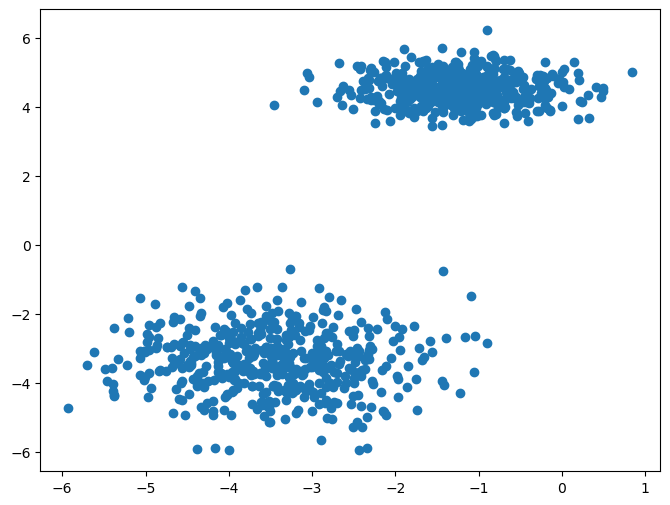

In [96]:
# plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1])

In [97]:
def initialize_parameters(X, C):
    n_samples, n_features = X.shape
    pis = np.ones(C) / C # (C,) vector of initial class probabilities
    mus = X[np.random.choice(n_samples, C, False)] # (C x d) matrix of initial mean guesses
    sigmas = [np.eye(n_features)] * C # (C x d x d) tensor of initial covariance guesses
    return pis, mus, sigmas

# Multivariate Normal PDF
def MVN_pdf(X: np.array, mu: np.array, sigma: np.array):
    _, n_features = X.shape
    coeff = 1 / np.sqrt((2 * np.pi) ** n_features * np.linalg.det(sigma))
    diff = X - mu
    inv_sigma = np.linalg.inv(sigma)
    exponent = -0.5 * np.sum(diff @ inv_sigma * diff, axis=1)
    return coeff * np.exp(exponent)


In [99]:
def plot_gaussian_ellipse(ax, mean, cov, color, alpha=0.3, std_multiplier=2):
    # Get eigenvalues and eigenvectors of the covariance matrix
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    
    # Get the angle of rotation from largest eigenvector
    theta = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    # Get width and height of ellipse from eigenvalues
    width, height = 2 * std_multiplier * np.sqrt(eigenvals)
    
    # Create and add the ellipse to the plot
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, 
                     facecolor=color, alpha=alpha, edgecolor=color)
    ax.add_patch(ellipse)
    return ax

def visualize_em_step(X, gamma, mus, sigmas, step, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    # Assign points to clusters based on highest responsibility
    assignments = np.argmax(gamma, axis=1)
    colors = ['#FF69B4', '#4169E1']  # pink and blue
    
    # Plot points with their soft assignments
    for i, color in enumerate(colors):
        mask = assignments == i
        ax.scatter(X[mask, 0], X[mask, 1], c=color, alpha=0.6, label=f'Cluster {i+1}')
        # Plot the Gaussian ellipse
        plot_gaussian_ellipse(ax, mus[i], sigmas[i], color)
    
    ax.set_title(f'EM Iteration {step}')
    ax.legend()
    ax.grid(True, alpha=0.3)

In [100]:
class EM:
    def __init__(self, X, C, max_iters=100):
        self.X = X
        self.C = C
        self.N = X.shape[0]
        self.pis, self.mus, self.sigmas = initialize_parameters(self.X, self.C)
        self.gamma = np.zeros((self.N, self.C))  # responsibility matrix
        self.log_likelihood_history = []
        
    def e_step(self):
        for c in range(self.C):
            self.gamma[:, c] = self.pis[c] * MVN_pdf(self.X, self.mus[c], self.sigmas[c])
        total = np.sum(self.gamma, axis=1, keepdims=True) # (N x 1) vector of likelihoods
        total = np.where(total ==0, 1e-10, total) # division by zero handler
        self.gamma /= total # Bayes' theorem denominator
        self.log_likelihood_history.append(np.sum(np.log(total))) # Store log-likelihood for convergence monitoring
    
    def m_step(self):
        # Update mixing coefficients (class priors)
        N_k = np.sum(self.gamma, axis=0)  # effective number of points per component
        self.pis = N_k / self.N
        
        # Update means and covariances
        for c in range(self.C):
            # Compute weighted mean
            self.mus[c] = np.sum(self.gamma[:, c:c+1] * self.X, axis=0) / N_k[c]
            
            # Compute weighted covariance with regularization
            diff = self.X - self.mus[c]
            self.sigmas[c] = (diff.T @ (self.gamma[:, c:c+1] * diff)) / N_k[c]
    
    def fit(self, n_iters=20, visualization=True):
        # Show initial state
        if visualization:
            visualize_em_step(self.X, self.gamma, self.mus, self.sigmas, step=0)
            plt.pause(0.5)
            print('Done iteration 0')
        
        for i in range(n_iters):
            self.e_step()
            self.m_step()
            
            if visualization:
                visualize_em_step(self.X, self.gamma, self.mus, self.sigmas, i+1)
                plt.pause(0.5)
                print('Done iteration', i+1)
        
        if visualization:
            plt.show()

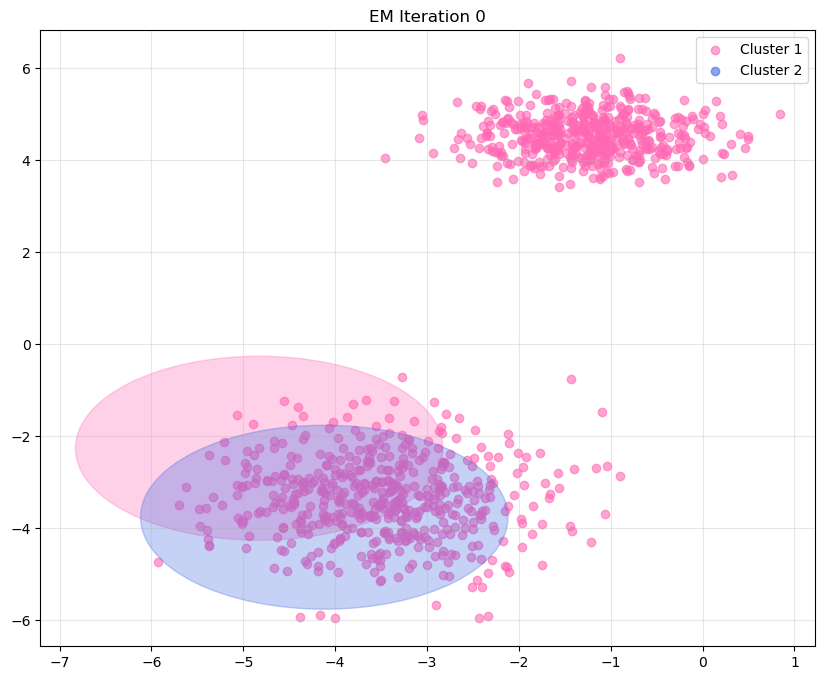

Done iteration 0


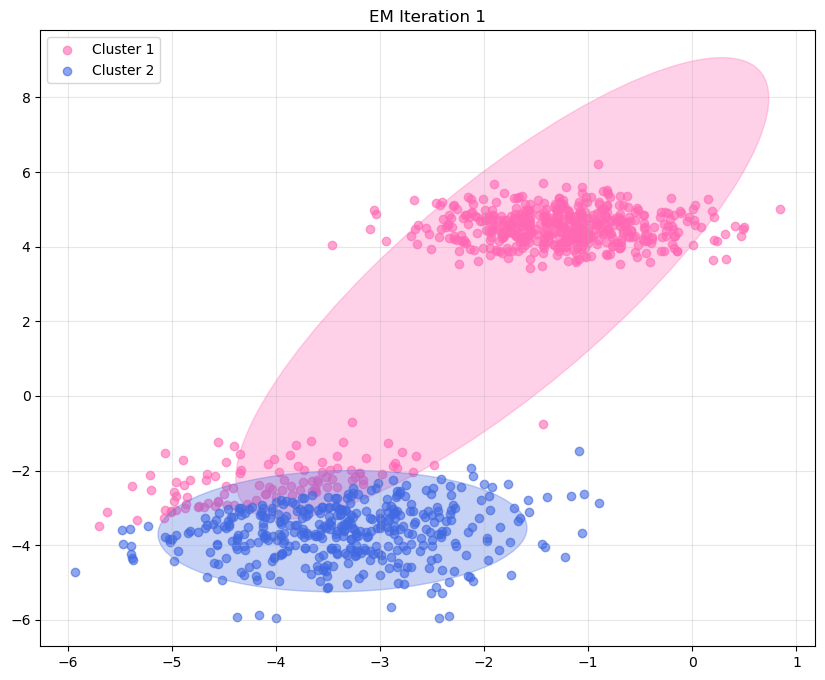

Done iteration 1


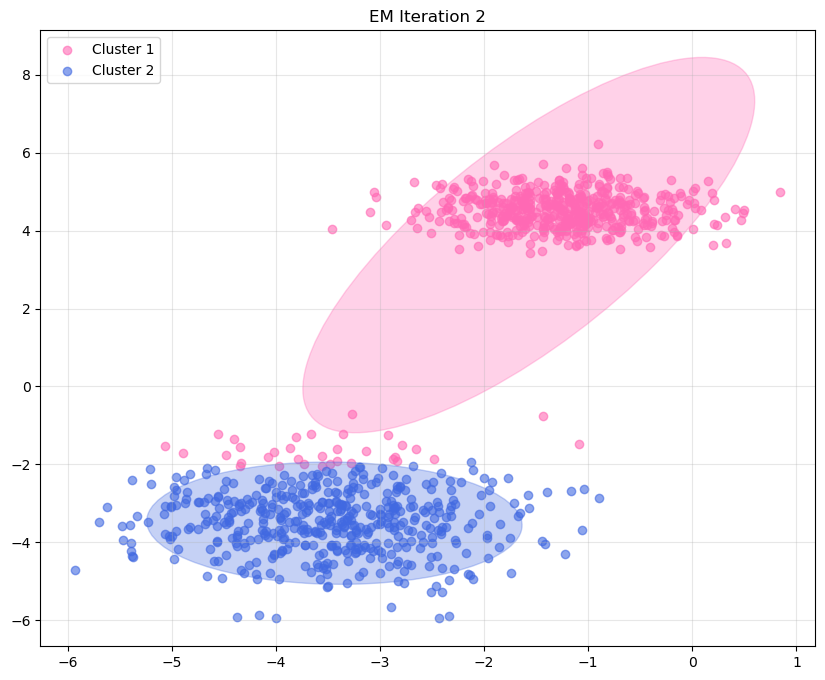

Done iteration 2


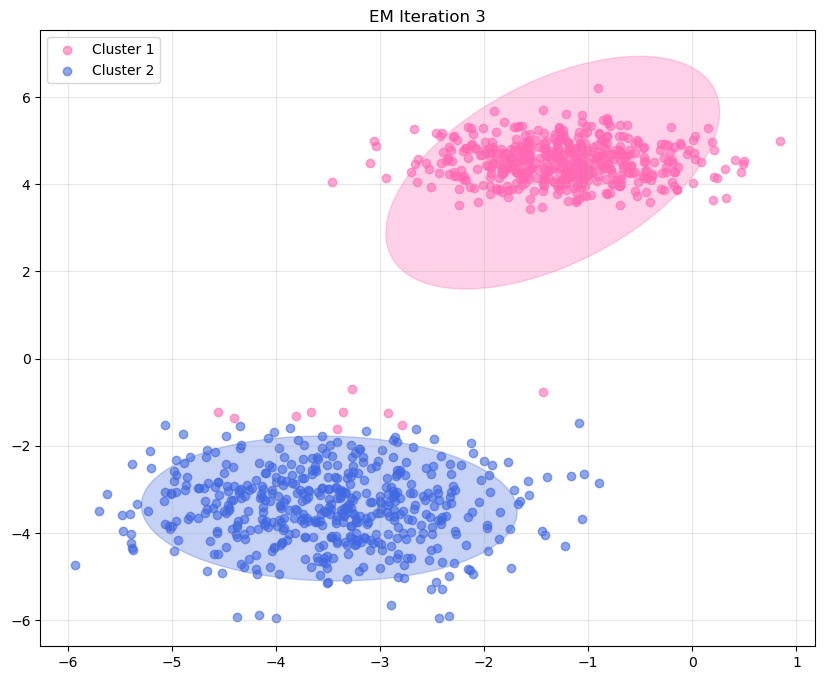

Done iteration 3


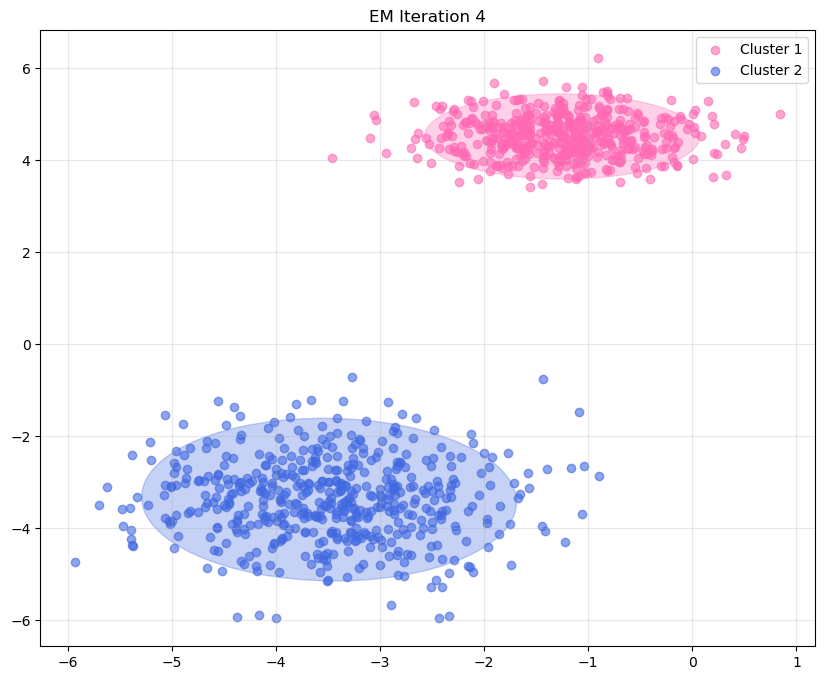

Done iteration 4


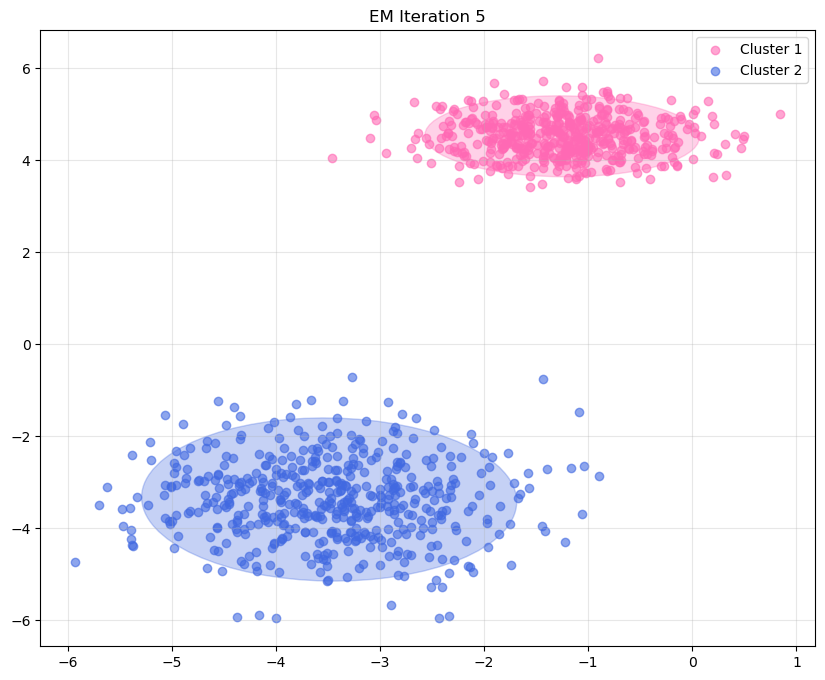

Done iteration 5


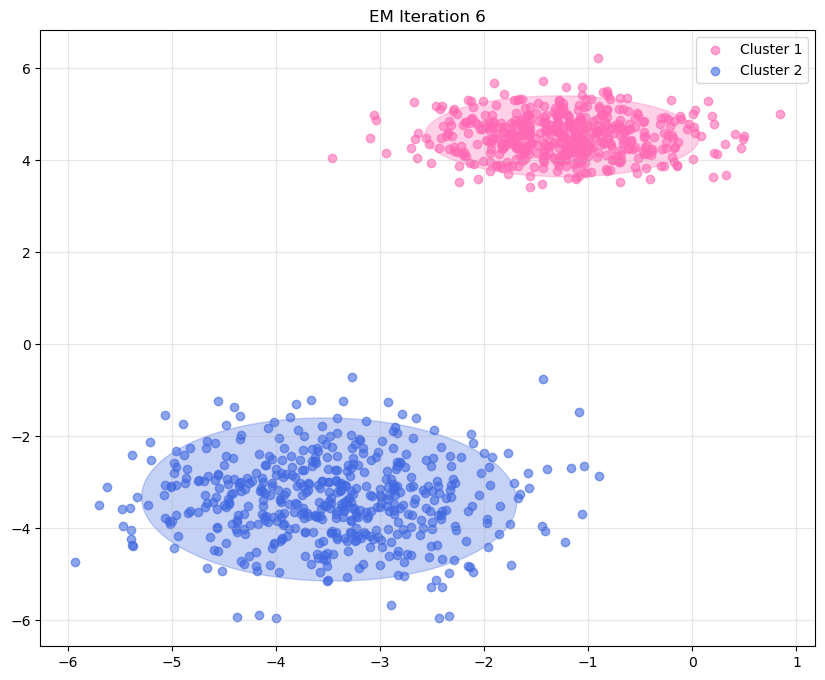

Done iteration 6


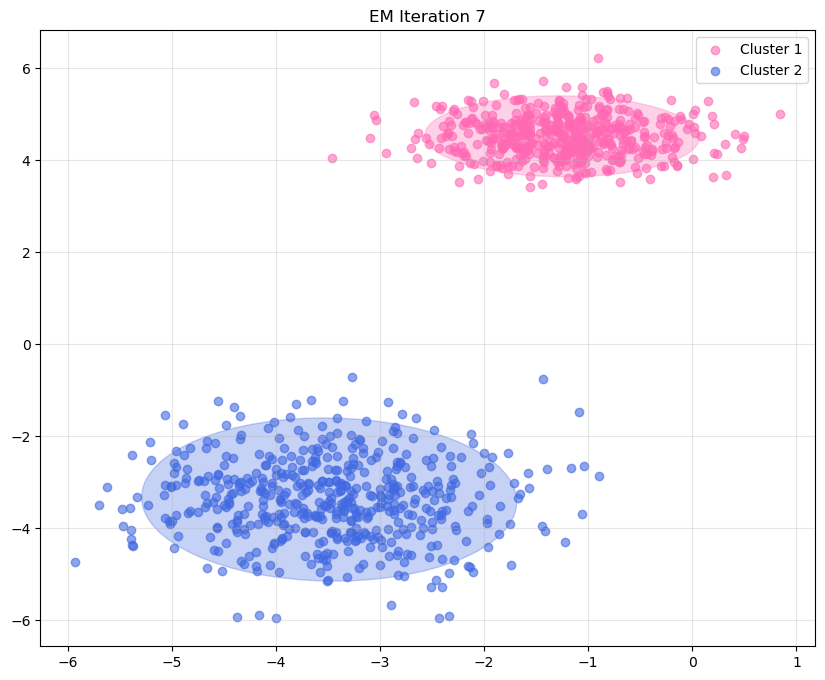

Done iteration 7


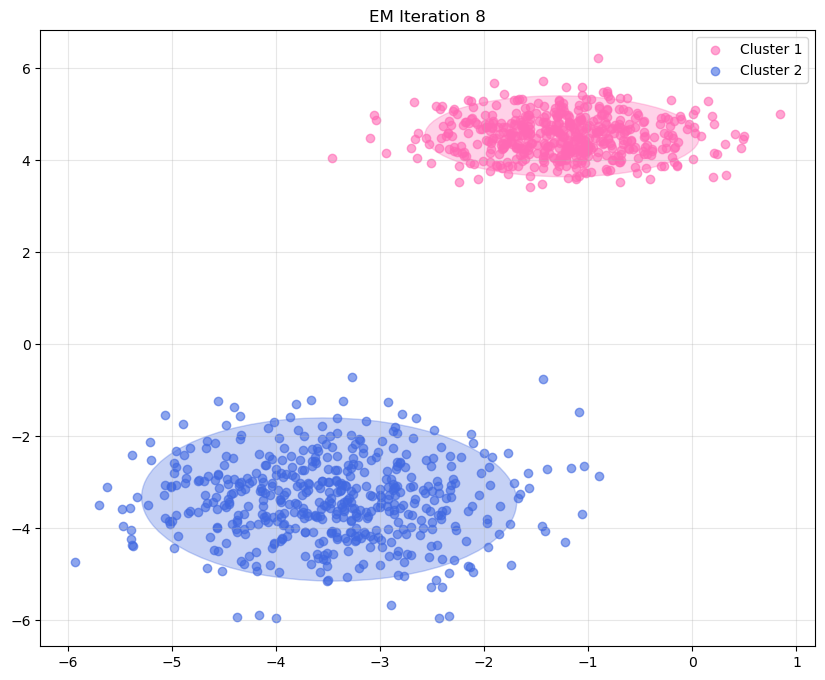

Done iteration 8


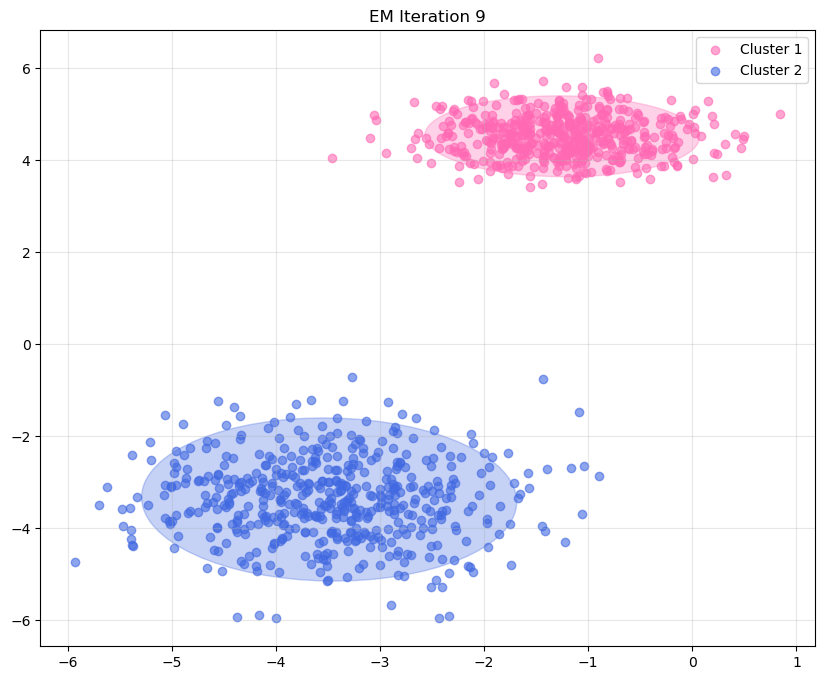

Done iteration 9


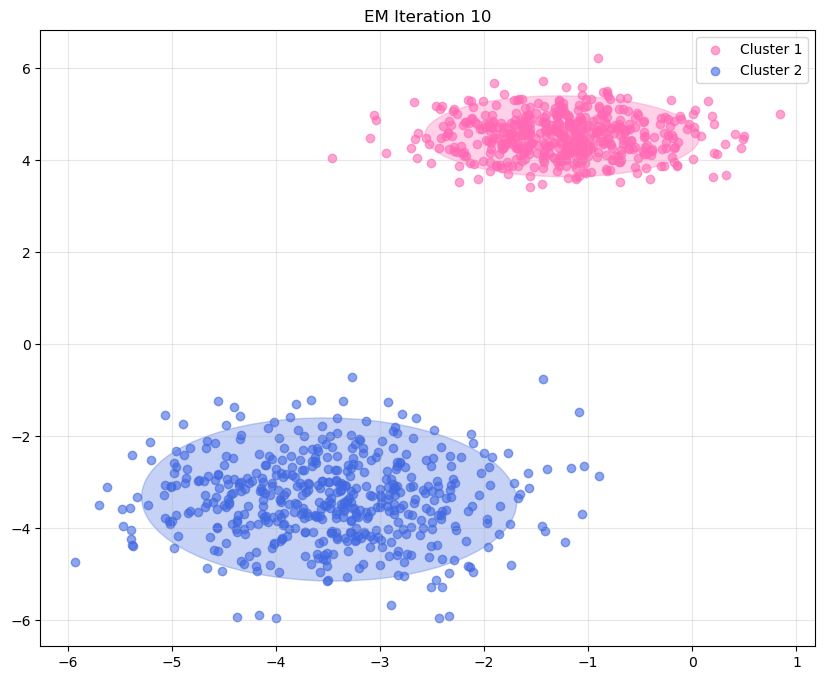

Done iteration 10


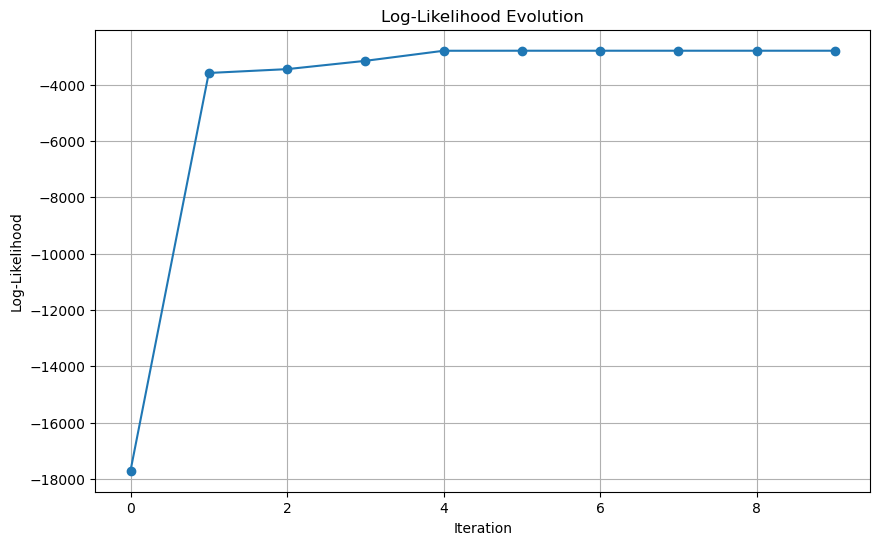

In [101]:
# Create and fit the EM model with visualization
np.random.seed(42)  # for reproducibility
EM_model = EM(X, C=2)
EM_model.fit(n_iters=10, visualization=True)

# Plot the final log-likelihood curve to show convergence
plt.figure(figsize=(10, 6))
plt.plot(EM_model.log_likelihood_history, '-o')
plt.title('Log-Likelihood Evolution')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()